# **Data Cleaning**

## Objectives
* Check for missing data.
* Investigate the effect of imputation methods for missing values.
* Clean data

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

### Missing data
There are 3 features that have missing values where all the feauters are typ is objects. If there are no row the overlap the maximum will be 

#### Effect 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance'

---

# Load Collected data

Section 1 content

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/StudentPerformance.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74


---

# Exploring dataset

In section the data will be explored and checking the distrubution and Data Cleaning we are interested to check the distribution and shape of a variable with missing data.

## Missing Data

Showned underneath is the features with missing data

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

print(f'Columns with missing data {vars_with_missing_data}.')

Columns with missing data ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'].


text of the code belowe

In [ ]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data])
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()

    # Add number of rows with can be droped
    number_of_missing_data = len(df.T.columns[df.T.isna().sum() > 0].to_list())
    total_missing_data_absolute = pd.Series([number_of_missing_data], index=['Total_rows'])
    missing_data_absolute = pd.concat([missing_data_absolute, total_missing_data_absolute])

    # Calculate the percentage of the dataset
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


In [7]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
Distance_from_Home,67,1.01,object
Parental_Education_Level,90,1.36,object
Teacher_Quality,78,1.18,object
Total_rows,229,3.47,NaN


## Correlation and PPS Analysis

By inspection correlation values for the missing vaules can we determant the more efficent way to clean the dataset. The function in the first box are function to plot the correlation and PPS values.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool_)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool_)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)
    
    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [10]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  380.0  0.002  0.022  0.0  0.0  0.0  0.0  0.316




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



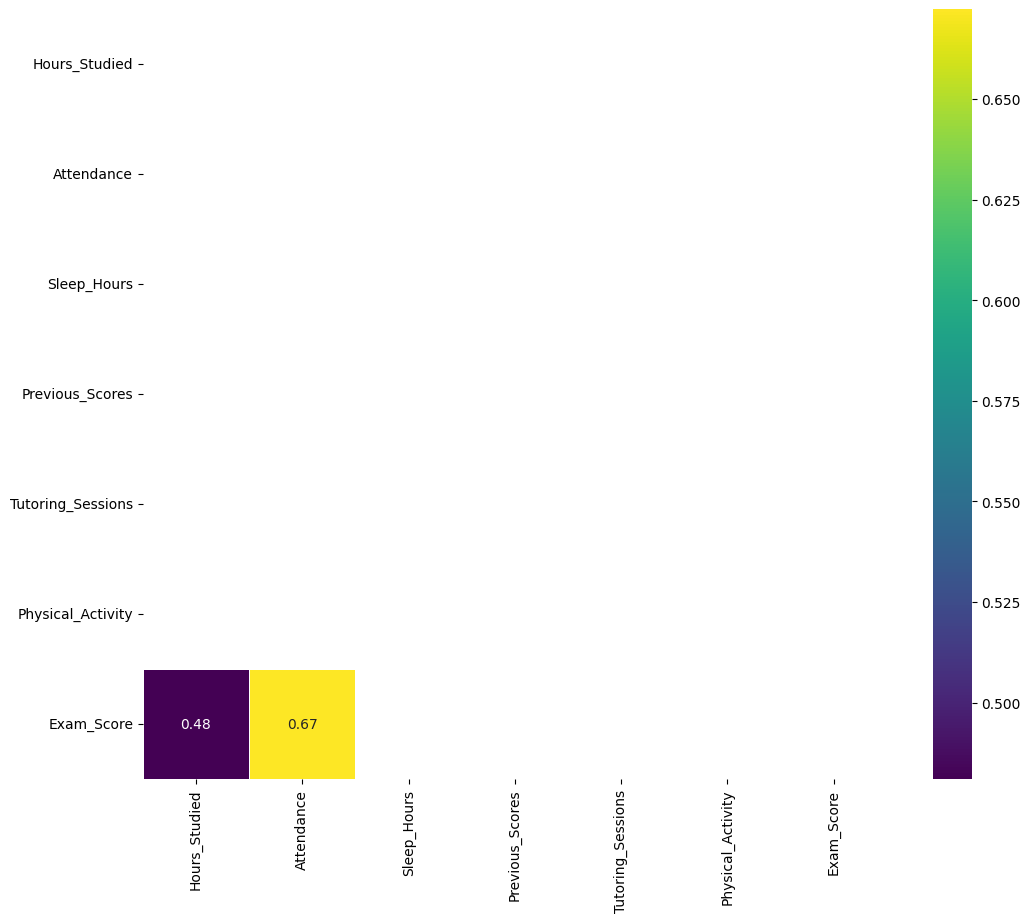



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



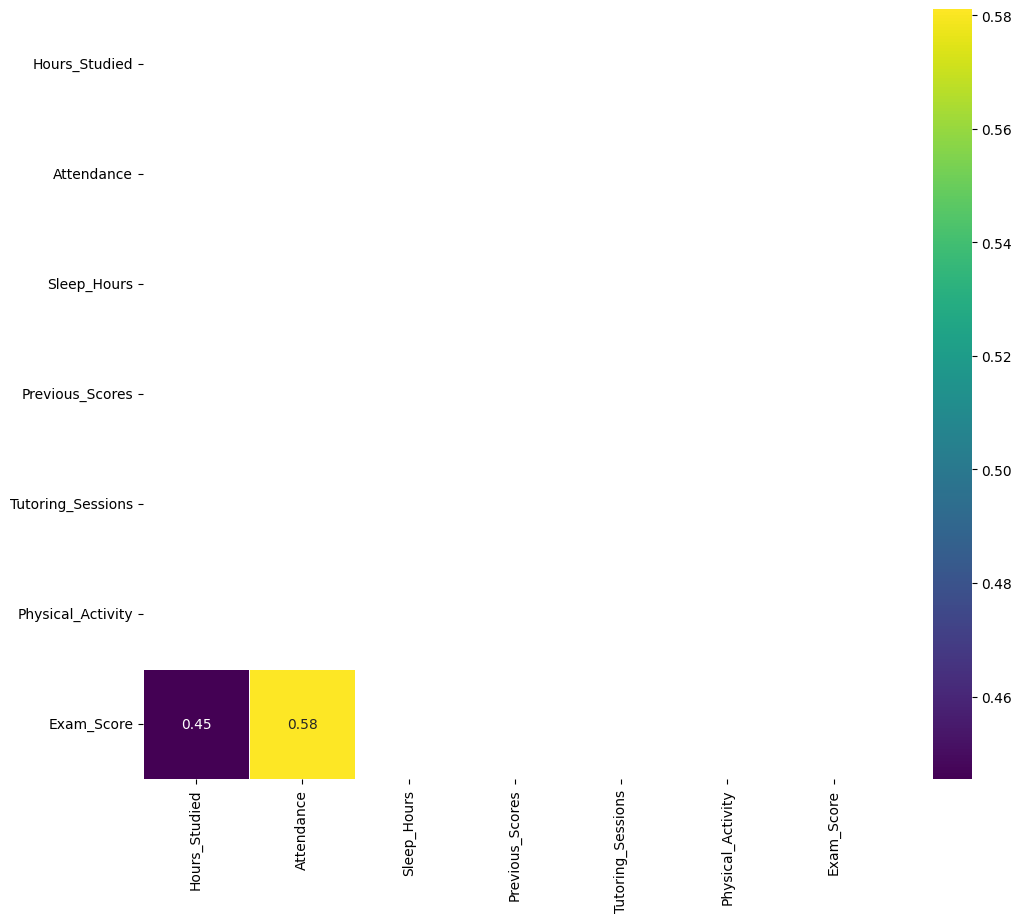



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



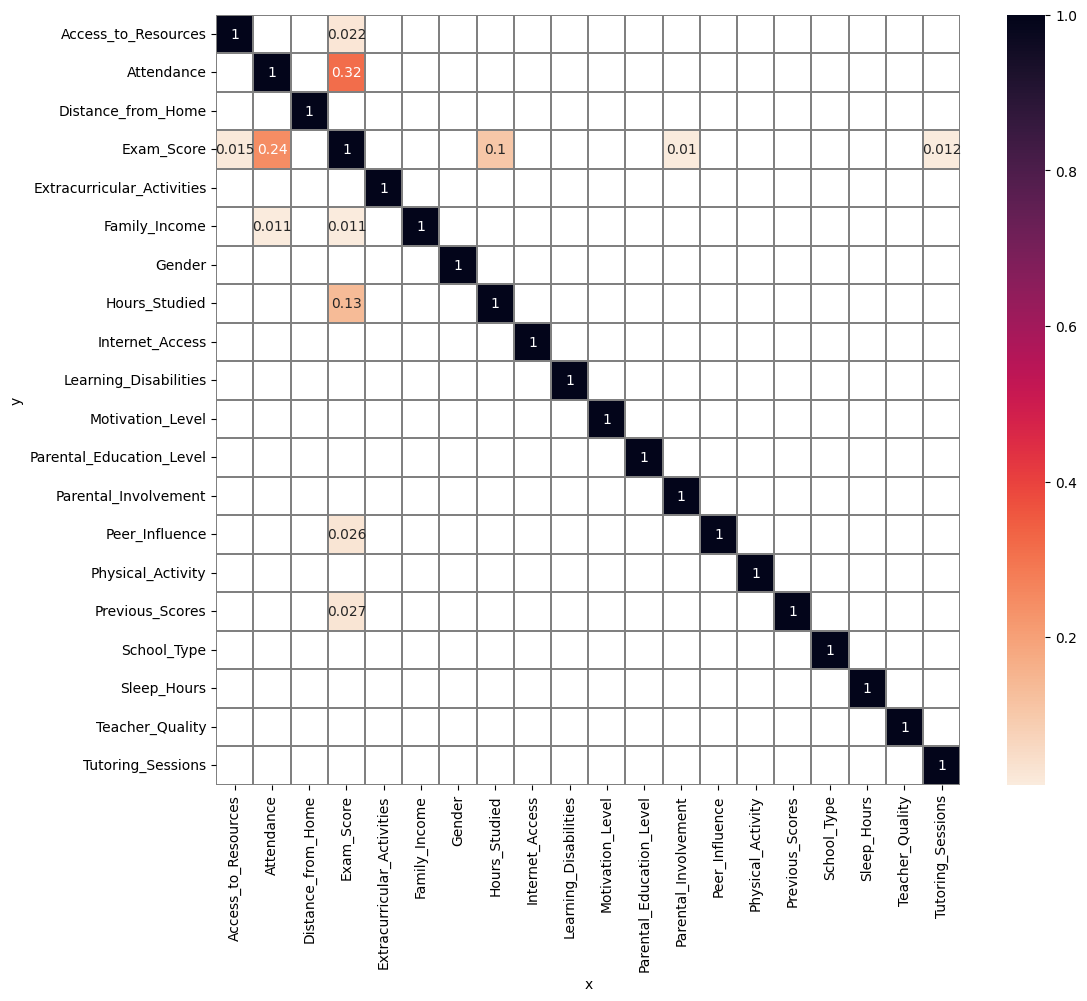

In [11]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.2, PPS_Threshold =0.002,
                  figsize=(12,10), font_annot=10)

Instead of replacing the missing data with 'Missing' the code underneath explors the best value to be replaces 'Missing' values with.

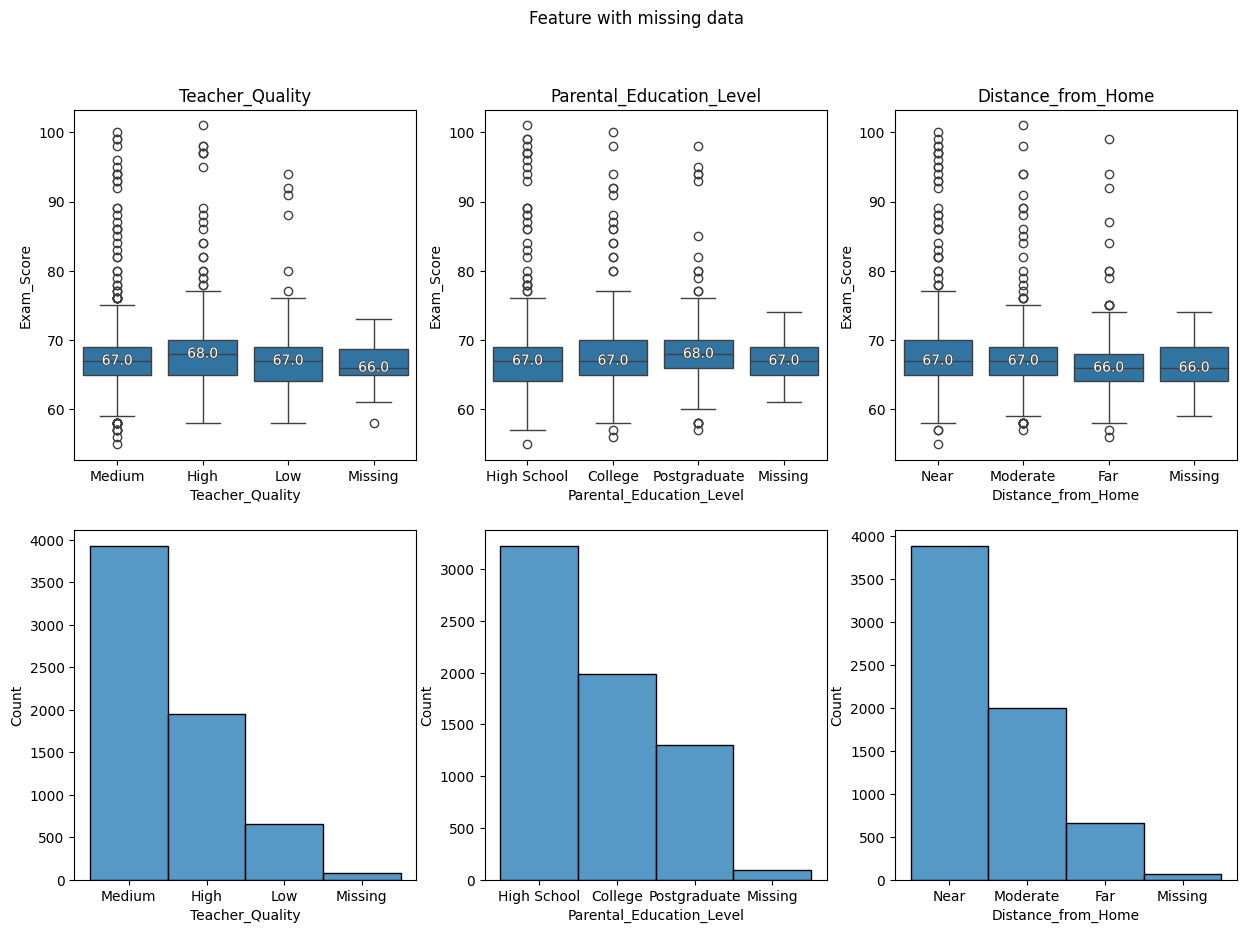

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.patheffects as path_effects
from feature_engine.imputation import CategoricalImputer


# sorce: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=1, foreground=median.get_color()),
            path_effects.Normal(),
        ])

# Creating av Pipline to insert 'Missing' instead of missing data
pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=vars_with_missing_data) )
])

df_nomissing_data = df.copy()
df_nomissing_data = pipeline.fit_transform(df_nomissing_data)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

ax1 = sns.boxplot(x=vars_with_missing_data[0], y='Exam_Score', data=df_nomissing_data, ax=axs[0,0])
add_median_labels(ax1)
ax1.set_title(vars_with_missing_data[0])


ax2 = sns.boxplot(x=vars_with_missing_data[1], y='Exam_Score', data=df_nomissing_data, ax=axs[0,1])
add_median_labels(ax2)
ax2.set_title(vars_with_missing_data[1])

ax3 = sns.boxplot(x=vars_with_missing_data[2], y='Exam_Score', data=df_nomissing_data, ax=axs[0,2])
add_median_labels(ax3)
ax3.set_title(vars_with_missing_data[2])

sns.histplot(x=vars_with_missing_data[0], data=df_nomissing_data, ax=axs[1,0])
sns.histplot(x=vars_with_missing_data[1], data=df_nomissing_data, ax=axs[1,1])
sns.histplot(x=vars_with_missing_data[2], data=df_nomissing_data, ax=axs[1,2])

fig.suptitle('Feature with missing data')
plt.show()

**Explain PLOTS**

Since the median value of the 'Missing' box have no destinct match in all three featurs the values for the moste commen varible have been choosen.

*Possible replacements insted of '**Missing**'*
| Columns   | Potential Approach |
| :-------- |  -------: |
| Teacher_Quality | Replacing with 'Medium' |
| Parental_Education_Level | Replacing with 'High School' |
| Distance_from_Home    | Replacing with 'Near' |

## Data Cleaning Spreadsheet and Summary

Since the numbers of the rows with missing data is minier there is not going to be a big loss in the dataset to drop the rows. However, even thou none of the features have a correlation with the target (*Exam_Score*) other values in the same row can have an effect on other features distrobutions. This is something that with be explored futhers in the next notebooke. It has also ecxplored to find the best value to giv instead of 'Missing', since all of the values in a feauter had the same or very close to the same median value the conclusion was made to select the most commen value. All thou since this can have can a effect and it is not necessary because of the scale of the missing data, this means that the first potential approaches to handle the missing data is replacing it with 'Missing', with replacing with most commen as a second approach followed with droping the rows.

| Columns   | Missing data | Type | Potential Approach
| :-------- | :-------: | ------- | -------: |
| Teacher_Quality | 67 | Object | Replacing with "*Missing*" |
| Parental_Education_Level | 90 | Object | Replacing with "*Missing*" |
| Distance_from_Home    | 78 | Object | Replacing with "*Missing*" |


# Cleaning Data

In [13]:
from sklearn.model_selection import train_test_split

df = pipeline.fit_transform(df)

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['Exam_Score'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (5285, 20) 
TestSet shape: (1322, 20)


Final check to see if there is any missing data in the Dataframe



In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [15]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)


## TrainSet

In [16]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## TestSet

In [17]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)